In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [2]:
def load_data(image_dir, mask_dir, img_size=(128, 128)):
    images = []
    masks = []
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_size)
        mask = cv2.resize(mask, img_size)
        images.append(img)
        masks.append(mask)
    images = np.array(images)[..., np.newaxis] / 255.0
    masks = np.array(masks)[..., np.newaxis] / 255.0
    return images, masks

In [3]:
image_dir = "./Brain Tumer Segmentation/images/"  
mask_dir = "./Brain Tumer Segmentation/masks/"    

# Check if directories exist
if not os.path.exists(image_dir):
	raise FileNotFoundError(f"The directory {image_dir} does not exist. Please provide a valid path.")
if not os.path.exists(mask_dir):
	raise FileNotFoundError(f"The directory {mask_dir} does not exist. Please provide a valid path.")

X, y = load_data(image_dir, mask_dir)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
def unet_model(input_shape=(128, 128, 1)):
    inputs = tf.keras.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    # Bottleneck
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    # Decoder
    u4 = layers.UpSampling2D()(c3)
    u4 = layers.Concatenate()([u4, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(c4)

    u5 = layers.UpSampling2D()(c4)
    u5 = layers.Concatenate()([u5, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)

    return Model(inputs, outputs)

In [5]:
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=16)

Epoch 1/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 109s 648ms/step - accuracy: 0.9821 - loss: 0.1781 - val_accuracy: 0.9823 - val_loss: 0.0662
Epoch 2/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 88s 573ms/step - accuracy: 0.9827 - loss: 0.0664 - val_accuracy: 0.9823 - val_loss: 0.0599
Epoch 3/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 84s 543ms/step - accuracy: 0.9824 - loss: 0.0601 - val_accuracy: 0.9823 - val_loss: 0.0565
Epoch 4/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 83s 536ms/step - accuracy: 0.9827 - loss: 0.0522 - val_accuracy: 0.9859 - val_loss: 0.0454
Epoch 5/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 82s 530ms/step - accuracy: 0.9855 - loss: 0.0444 - val_accuracy: 0.9866 - val_loss: 0.0418
Epoch 6/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 85s 550ms/step - accuracy: 0.9868 - loss: 0.0388 - val_accuracy: 0.9872 - val_loss: 0.0405
Epoch 7/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 84s 545ms/step - accuracy: 0.9872 - loss: 0.0376 - val_accuracy: 0.9862 - val_loss: 0.0413
Epoch 8/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 80s 522ms/step - accuracy: 0.9875 - loss: 

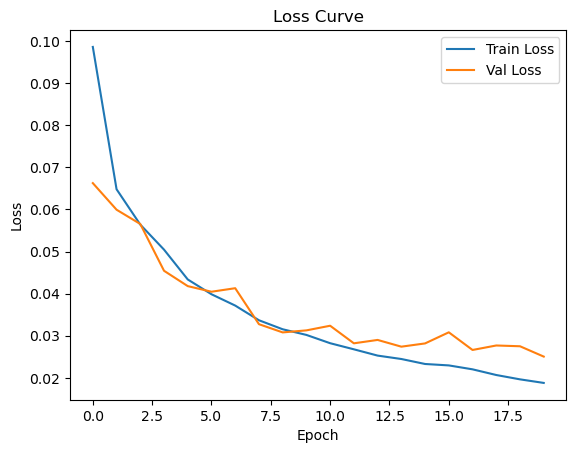

In [6]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [7]:
def display_prediction(index):
    pred = model.predict(X_val[index][np.newaxis, ...])[0, ..., 0]
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[index].squeeze(), cmap='gray')
    plt.title("Image")
    plt.subplot(1, 3, 2)
    plt.imshow(y_val[index].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.subplot(1, 3, 3)
    plt.imshow(pred > 0.5, cmap='gray')
    plt.title("Prediction")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


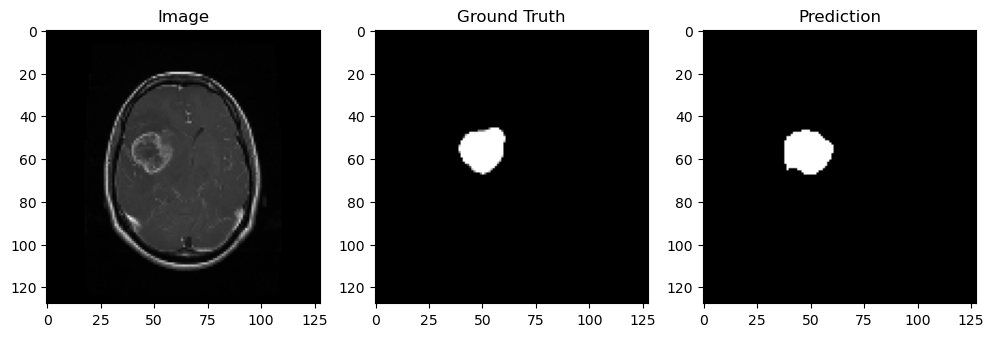

In [8]:
display_prediction(0)